In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
names=(["symboling","normalized-losses","make","fuel-type","aspiration",
        "num-of-doors","body-style","drive-wheels","engine-location",
        "wheel-base","length","width","height","curb-weight","engine-type",
        "num-of-cylinders","engine-size","fuel-system","bore","stroke",
        "compression-ratio","horsepower","peak-rpm","city-mpg","highway-mpg",
        "price"])

In [3]:
cars = pd.read_csv("imports-85.data", header=None)
cars.columns=names
cars.head()

symboling normalized-losses         make fuel-type aspiration num-of-doors  \
0          3                 ?  alfa-romero       gas        std          two   
1          3                 ?  alfa-romero       gas        std          two   
2          1                 ?  alfa-romero       gas        std          two   
3          2               164         audi       gas        std         four   
4          2               164         audi       gas        std         four   

    body-style drive-wheels engine-location  wheel-base  ...    engine-size  \
0  convertible          rwd           front        88.6  ...            130   
1  convertible          rwd           front        88.6  ...            130   
2    hatchback          rwd           front        94.5  ...            152   
3        sedan          fwd           front        99.8  ...            109   
4        sedan          4wd           front        99.4  ...            136   

   fuel-system  bore  stroke compression-ratio horsepower  peak-rpm city-mpg  \
0         mpfi  3.47    2.68               9.0        111      5000       21   
1         mpfi  3.47    2.68               9.0        111      5000       21   
2         mpfi  2.68    3.47               9.0        154      5000       19   
3         mpfi  3.19    3.40              10.0        102      5500       24   
4         mpfi  3.19    3.40               8.0        115      5500       18   

  highway-mpg  price  
0          27  13495  
1          27  16500  
2          26  16500  
3          30  13950  
4          22  17450  

[5 rows x 26 columns]

In [4]:
cars.replace("?",np.nan, inplace=True)

In [5]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
symboling            205 non-null int64
normalized-losses    164 non-null object
make                 205 non-null object
fuel-type            205 non-null object
aspiration           205 non-null object
num-of-doors         203 non-null object
body-style           205 non-null object
drive-wheels         205 non-null object
engine-location      205 non-null object
wheel-base           205 non-null float64
length               205 non-null float64
width                205 non-null float64
height               205 non-null float64
curb-weight          205 non-null int64
engine-type          205 non-null object
num-of-cylinders     205 non-null object
engine-size          205 non-null int64
fuel-system          205 non-null object
bore                 201 non-null object
stroke               201 non-null object
compression-ratio    205 non-null float64
horsepower           203 non-nul

In [6]:
def st2num(val):
    if val == "one": return 1
    elif val == "two": return 2
    elif val == "three": return 3
    elif val == "four": return 4
    elif val == "five": return 5
    elif val == "six": return 6
    elif val == "seven": return 7
    elif val == "eight": return 8
    elif val == "nine": return 9
    elif val == "ten": return 10
    elif val == "eleven": return 11
    elif val == "twelve": return 12
    else: return np.nan    

In [7]:
cars["num-of-doors"] = cars["num-of-doors"].apply(st2num)
cars["num-of-cylinders"] = cars["num-of-cylinders"].apply(st2num)
cars["normalized-losses"] = cars["normalized-losses"].astype(float)
cars["curb-weight"] = cars["curb-weight"].astype(int)
cars["bore"] = cars["bore"].astype(float)
cars["stroke"] = cars["stroke"].astype(float)
cars["horsepower"] = cars["horsepower"].astype(float)
cars["peak-rpm"] = cars["peak-rpm"].astype(float)
cars["price"] = cars["price"].astype(float)
cars.drop("normalized-losses", axis=1, inplace=True)

In [8]:
cars.dropna(inplace=True)

In [9]:
cars = (cars[["symboling", "num-of-doors", "wheel-base",
                   "length", "width","height","curb-weight",
                  "num-of-cylinders","engine-size","bore",
                  "stroke","compression-ratio","horsepower",
                  "peak-rpm","city-mpg","highway-mpg", "price"]])

In [10]:
cars = (cars - cars.min()) / (cars.max() - cars.min())

In [11]:
cars.head()

symboling  num-of-doors  wheel-base    length     width    height  \
0        1.0           0.0    0.058309  0.413433  0.324786  0.083333   
1        1.0           0.0    0.058309  0.413433  0.324786  0.083333   
2        0.6           0.0    0.230321  0.449254  0.444444  0.383333   
3        0.8           1.0    0.384840  0.529851  0.504274  0.541667   
4        0.8           1.0    0.373178  0.529851  0.521368  0.541667   

   curb-weight  num-of-cylinders  engine-size      bore    stroke  \
0     0.411171          0.111111     0.260377  0.664286  0.290476   
1     0.411171          0.111111     0.260377  0.664286  0.290476   
2     0.517843          0.333333     0.343396  0.100000  0.666667   
3     0.329325          0.111111     0.181132  0.464286  0.633333   
4     0.518231          0.222222     0.283019  0.464286  0.633333   

   compression-ratio  horsepower  peak-rpm  city-mpg  highway-mpg     price  
0             0.1250    0.294393  0.346939  0.222222     0.289474  0.207959  
1             0.1250    0.294393  0.346939  0.222222     0.289474  0.282558  
2             0.1250    0.495327  0.346939  0.166667     0.263158  0.282558  
3             0.1875    0.252336  0.551020  0.305556     0.368421  0.219254  
4             0.0625    0.313084  0.551020  0.138889     0.157895  0.306142

In [12]:
def knn_train_test(train_col_name, target_col_name, df):
    kf = KFold(5, shuffle=True, random_state=1)
    knn = KNeighborsRegressor()
    mses = cross_val_score(knn, df[[train_col_name]], df[target_col_name],
                          scoring="neg_mean_squared_error", cv=kf)
    return (np.sqrt(np.mean(mses**2)))

In [13]:
for name in cars.columns:
    if name != "price":
        x = knn_train_test(name,"price", cars)
        x = round(x,3)
        print(name + " rmse = " + str(x))

symboling rmse = 0.054
num-of-doors rmse = 0.049
wheel-base rmse = 0.02
length rmse = 0.018
width rmse = 0.013
height rmse = 0.037
curb-weight rmse = 0.011
num-of-cylinders rmse = 0.044
engine-size rmse = 0.007
bore rmse = 0.038
stroke rmse = 0.036
compression-ratio rmse = 0.03
horsepower rmse = 0.01
peak-rpm rmse = 0.037
city-mpg rmse = 0.01
highway-mpg rmse = 0.012


In [14]:
def knn_train_test(train_col_name, target_col_name, df, k):
    kf = KFold(5, shuffle=True, random_state=1)
    knn = KNeighborsRegressor(n_neighbors=k)
    mses = cross_val_score(knn, df[[train_col_name]], df[target_col_name],
                          scoring="neg_mean_squared_error", cv=kf)
    return (np.sqrt(np.mean(mses**2)))

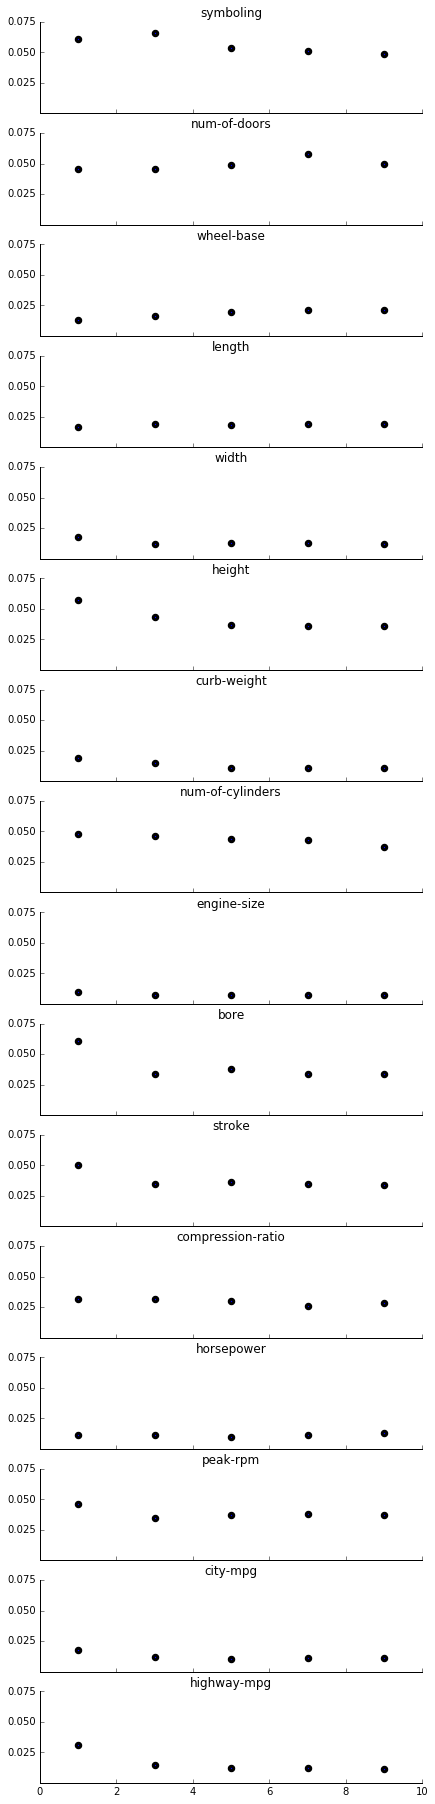

In [15]:
fig, axs = plt.subplots(16, figsize=(6,25), sharex='col')
fig.tight_layout()
for ii in range(len(cars.columns)):
    name = cars.columns[ii]
    for k in [1,3,5,7,9]:
        if name != "price":
            x = knn_train_test(name, "price", cars, k)
            x = round(x,3)
            axs[ii].scatter(k,x, linewidth=3)
            axs[ii].set_title(name)
            axs[ii].spines['right'].set_visible(False)
            axs[ii].spines['top'].set_visible(False)
            axs[ii].yaxis.set_ticks_position('left')
            axs[ii].xaxis.set_ticks_position('bottom')
            axs[ii].set_ylim(0, 0.075)
            axs[ii].set_yticks([0.025,0.050,0.075])

In [16]:
def knn_train_test(train_col_names, target_col_name, df):
    kf = KFold(5, shuffle=True, random_state=1)
    knn = KNeighborsRegressor()
    mses = cross_val_score(knn, df[train_col_names], df[target_col_name],
                          scoring="neg_mean_squared_error", cv=kf)
    return (np.sqrt(np.mean(mses**2)))

In [17]:
two_best = ["engine-size", "horsepower"]
three_best = ["engine-size", "horsepower", "city-mpg"]
four_best = ["engine-size", "horsepower", "city-mpg", "highway-mpg"]
five_best = ["engine-size", "horsepower", "city-mpg", "highway-mpg", "curb-weight"]
top_features = [two_best, three_best, four_best, five_best]

In [18]:
for ii in range(len(top_features)):
    val = top_features[ii]
    rmse = knn_train_test(val, "price", cars)
    print("top " + str(ii+2) + ", RMSE = " + str(round(rmse,5)))

top 2, RMSE = 0.00631
top 3, RMSE = 0.00608
top 4, RMSE = 0.00626
top 5, RMSE = 0.00717


In [19]:
def knn_train_test(train_col_names, target_col_name, df, k):
    kf = KFold(5, shuffle=True, random_state=1)
    knn = KNeighborsRegressor(n_neighbors=k)
    mses = cross_val_score(knn, df[train_col_names], df[target_col_name],
                          scoring="neg_mean_squared_error", cv=kf)
    return (np.sqrt(np.mean(mses**2)))

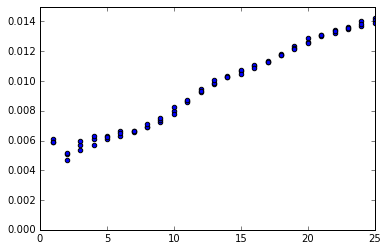

In [20]:
best_models = [two_best, three_best, four_best]
for k in range(1,26):
    for ii in range(len(best_models)):
        model = best_models[ii]
        rmse = knn_train_test(model, "price", cars, k)
        plt.scatter(k,rmse)
        plt.xlim(0,25)
        plt.ylim(0,0.015)

# Observations:
- The optimal hyperparameter k value appears to be 2.  As k increases, RMSE values increase. 
- The variability of models is relatively high at low-k values, and decreasing as k increases. 
- The overall RMSE value is extremely close regardless of model or k value choice